# Clinvar plots

## Preliminaries

### Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [2]:
df = pd.read_csv("../outputs/clinvar_variants_lof_with_nmd_annotation.tsv", sep="\t")

## Plot the proportion of VUS by NMD annotation

In [168]:
dfg = df.groupby(["csq", "variant_region"])

In [169]:
df1 = dfg["acmg"].value_counts(normalize=True).rename("proportion").reset_index()

df1["variant_region"] = pd.Categorical(
    df1["variant_region"],
    categories=["nmd", "start_proximal", "long_exon", "distal"],
    ordered=True,
)

In [170]:
# Choose the colorblind palette
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [171]:
# Pathogenic = red, VUS = grey, benign = blue
sns.set_palette([sns.color_palette("colorblind").as_hex()[i] for i in [3, -3, 0]])
sns.set_context("talk")

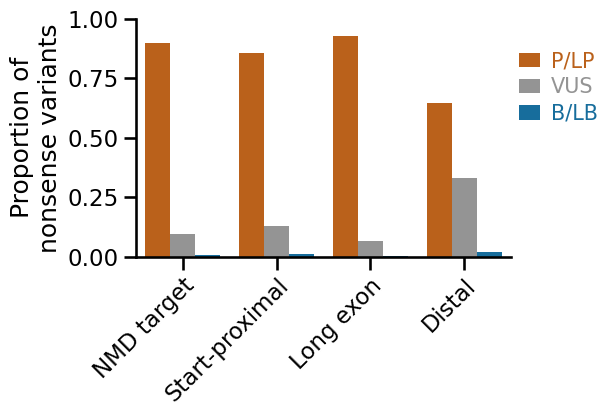

In [175]:
fig, ax = plt.subplots(figsize=(6.5, 4.5), layout="tight")

sns.barplot(
    ax=ax,
    data=df1[df1["csq"] == "stop_gained"],
    x="variant_region",
    y="proportion",
    hue="acmg",
    hue_order=["P/LP", "VUS", "B/LB"],
)
ax.set_xlabel(None)
ax.set_ylabel("Proportion of\nnonsense variants")
ax.set_xticks(
    ticks=range(4),
    labels=["NMD target", "Start-proximal", "Long exon", "Distal"],
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)
ax.set_yticks(ticks=[0, 0.25, 0.5, 0.75, 1])
ax.spines[["top", "right"]].set_visible(False)
ax.legend(
    title=None,
    frameon=False,
    fontsize="small",
    labelspacing=0.3,
    columnspacing=1,
    handlelength=1,
    handletextpad=0.5,
    labelcolor="linecolor",
    bbox_to_anchor=(1, 0.9),
    borderaxespad=0,
    # ncols=3
)
plt.savefig("../plots/clinvar_nonsense_acmg_by_region.svg", format="svg")

## Reformat the data to long-form

In [15]:
dfa = df.melt(
    id_vars=["enst", "variant_region", "acmg"],
    value_vars=["gnomad", "nmd", "distal", "long_exon"],
    var_name="constraint_region",
    value_name="constraint",
)

### Filter ClinVar variants 
Keep those which:
- Fall in a transcript with a gnomAD constraint annotation
- Are in a region with a constraint annotation

In [16]:
m1 = dfa.constraint_region == "gnomad"
m2 = dfa.variant_region == dfa.constraint_region

dfa = dfa[m1 | m2].dropna()

### What proportion of variants are pathogenic / benign / VUS? 

In [17]:
prop = (
    dfa.groupby(["constraint_region", "constraint"])["acmg"]
    .value_counts(normalize=True)
    .reset_index(name="Proportion")
    .replace(
        {
            "gnomad": "gnomAD",
            "nmd": "NMD-target",
            "distal": "Distal",
            "long_exon": "Long exon",
            "tolerant": "Tolerant",
            "constrained": "Constrained",
        }
    )
    .rename(columns={"constraint": "Constraint", "acmg": "ACMG"})
)

## Plot the data

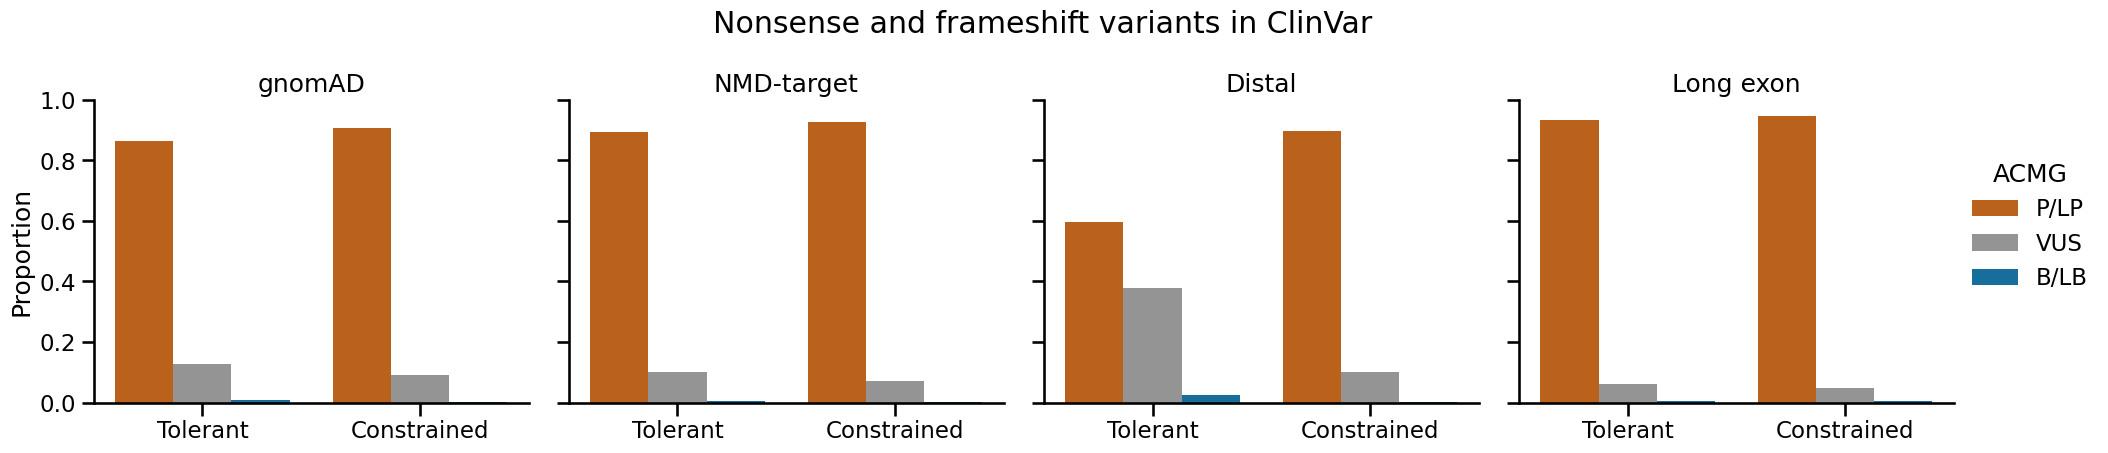

In [24]:
# Construct a bar plot

g = sns.catplot(
    kind="bar",
    data=prop,
    x="Constraint",
    order=["Tolerant", "Constrained"],
    hue="ACMG",
    hue_order=["P/LP", "VUS", "B/LB"],
    col="constraint_region",
    col_order=["gnomAD", "NMD-target", "Distal", "Long exon"],
    y="Proportion",
)
g.set(xlabel="", ylim=(0, 1))
g.set_titles(template="{col_name}")
g.fig.suptitle("Nonsense and frameshift variants in ClinVar")
g.fig.subplots_adjust(top=0.8)

## Tabulate the data

In [21]:
a = (
    dfa.groupby(["constraint_region", "constraint", "acmg"])
    .agg({"enst": "count"})
    .rename(columns={"enst": "Variant count"})
)
b = (
    dfa.groupby(["constraint_region", "constraint"])["acmg"]
    .value_counts(normalize=True)
    .rename("Proportion")
)

stats = (
    a.merge(b, left_index=True, right_index=True)
    .reset_index()
    .pivot(
        index="acmg",
        columns=["constraint_region", "constraint"],
        values=["Variant count", "Proportion"],
    )
    .swaplevel(0, 1, axis=1)
    .swaplevel(1, 2, axis=1)
    .sort_index(level=0, axis=1, sort_remaining=True)
)
stats

constraint_region      distal                                         \
constraint        constrained                 tolerant                 
                   Proportion Variant count Proportion Variant count   
acmg                                                                   
B/LB                 0.003291          11.0   0.026493         244.0   
P/LP                 0.894973        2991.0   0.594680        5477.0   
VUS                  0.101735         340.0   0.378827        3489.0   

constraint_region      gnomad                                         \
constraint        constrained                 tolerant                 
                   Proportion Variant count Proportion Variant count   
acmg                                                                   
B/LB                 0.002615          85.0   0.008368         593.0   
P/LP                 0.905388       29426.0   0.864044       61227.0   
VUS                  0.091997        2990.0   0.127588        9041.0   

constraint_region   long_exon                                         \
constraint        constrained                 tolerant                 
                   Proportion Variant count Proportion Variant count   
acmg                                                                   
B/LB                 0.006452          18.0   0.004582          30.0   
P/LP                 0.944803        2636.0   0.933568        6113.0   
VUS                  0.048746         136.0   0.061851         405.0   

constraint_region         nmd                                         
constraint        constrained                 tolerant                
                   Proportion Variant count Proportion Variant count  
acmg                                                                  
B/LB                 0.001927          52.0   0.006918         209.0  
P/LP                 0.926790       25015.0   0.891555       26933.0  
VUS                  0.071283        1924.0   0.101526        3067.0